In [4]:
%cd /content/drive/MyDrive/Assignment Robotics

/content/drive/MyDrive/Assignment Robotics


In [5]:
!pip install gradio

In [6]:
!pip install icecream

In [7]:
!pip install mlflow dvc

In [8]:
from icecream import ic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import re
import gc
import mlflow
import dvc.api
import joblib
import os
from scipy.stats import zscore
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [9]:
dir_path = "/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer"

In [10]:
dir_path  + "/*.csv"

'/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/*.csv'

In [11]:
files_path=glob(dir_path+"/*.csv")
files_path

['/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/11.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/1.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/12.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/13.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/10.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/2.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/14.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/4.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/15.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/5.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/3.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/9.csv',
 '/content/drive/MyDrive/Assignment Robotics/ActivityAccelerometer/8.csv',
 '/content/drive/My

In [12]:
def Dataframe(files_path):
    df_participants=pd.DataFrame()
    for index,file_path in enumerate(files_path):
        df=pd.read_csv(file_path,header=None)
        df["User_id"]=int(re.sub(r'[^0-9]',"",file_path))
        df_participants=df_participants.append(df.iloc[:,1:])
    return df_participants

In [13]:
data = Dataframe(files_path)

In [14]:
data

,1,2,3,4,User_id
0,1983,2438,1825,1,11
1,1948,2442,1797,1,11
2,1927,2388,1784,1,11
3,1960,2319,1831,1,11
4,1967,2274,1871,1,11
...,...,...,...,...,...
140896,2098,2305,1982,7,6
140897,2106,2314,1980,7,6
140898,2112,2319,1973,7,6
140899,2111,2319,1969,7,6


In [15]:
data.columns = ['x_acceleration','y_acceleration','z_acceleration','Label','User_id']

In [16]:
data.index = range(len(data))

In [17]:
data=data.reindex(columns=["User_id","x_acceleration","y_acceleration","z_acceleration","Label"])
data

,User_id,x_acceleration,y_acceleration,z_acceleration,Label
0,11,1983,2438,1825,1
1,11,1948,2442,1797,1
2,11,1927,2388,1784,1
3,11,1960,2319,1831,1
4,11,1967,2274,1871,1
...,...,...,...,...,...
1926891,6,2098,2305,1982,7
1926892,6,2106,2314,1980,7
1926893,6,2112,2319,1973,7
1926894,6,2111,2319,1969,7


In [18]:
data.User_id.value_counts().sort_index()

1     162501
2     138001
3     102341
4     122201
5     160001
6     140901
7     163001
8     138001
9     166741
10    126801
11    104451
12    114702
13     67651
14    116101
15    103501
Name: User_id, dtype: int64

In [19]:
data.isnull().sum()

User_id           0
x_acceleration    0
y_acceleration    0
z_acceleration    0
Label             0
dtype: int64

In [20]:
data.describe()

,User_id,x_acceleration,y_acceleration,z_acceleration,Label
count,1.926896e+06,1.926896e+06,1.926896e+06,1.926896e+06,1.926896e+06
mean,7.512711e+00,1.987652e+03,2.382523e+03,1.970596e+03,3.882898e+00
std,4.172396e+00,1.113578e+02,1.003151e+02,9.445893e+01,2.443402e+00
min,1.000000e+00,2.820000e+02,2.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,1.904000e+03,2.337000e+03,1.918000e+03,1.000000e+00
50%,7.000000e+00,1.992000e+03,2.367000e+03,1.988000e+03,4.000000e+00
75%,1.100000e+01,2.076000e+03,2.413000e+03,2.032000e+03,7.000000e+00
max,1.500000e+01,3.828000e+03,4.095000e+03,4.095000e+03,7.000000e+00


In [21]:
data.drop(list(data[data.Label==0].index),axis=0,inplace=True)
data.set_axis(range(len(data)),axis=0,inplace=True)
A_x=np.square(data['x_acceleration'])
A_y=np.square(data['y_acceleration'])
A_z=np.square(data['z_acceleration'])
A_m=np.sqrt(A_x + A_y + A_z)
data["mag_acceleration"]=A_m
data=data.reindex(["User_id","x_acceleration","y_acceleration","z_acceleration","mag_acceleration","Label"],axis=1)

EDA

In [22]:
data.corr().Label.sort_values()

User_id            -0.168296
z_acceleration      0.035025
y_acceleration      0.048724
mag_acceleration    0.074253
x_acceleration      0.077737
Label               1.000000
Name: Label, dtype: float64

<Axes: >

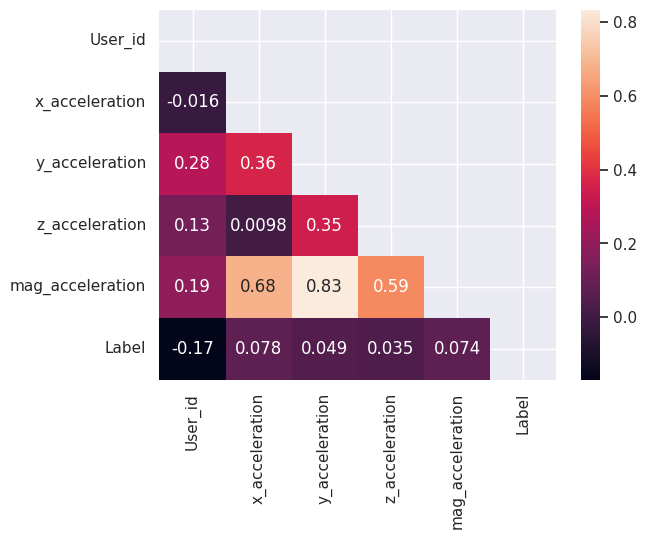

In [23]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), mask=mask,annot=True)

Model Selection

In [23]:
x=data.iloc[:,:-1]
y=data.iloc[:,-1:]

In [24]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=117)
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

Searching for the optimal value of K

In [25]:
non_y=[]
for i in range(1,10):
    knn=KNeighborsClassifier(n_neighbors=i,p=2)
    knn.fit(train_x,train_y)
    optimal_y=knn.predict(test_x)
    optimal_y=optimal_y.reshape(len(optimal_y),1)
    non_y.append(np.mean(optimal_y!=test_y))

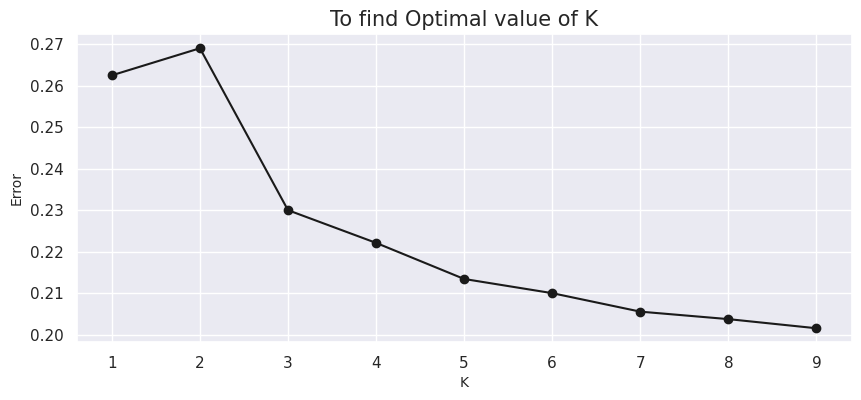

In [26]:
fig=plt.gcf()
fig.set_size_inches((10,4))
plt.plot(range(1,len(non_y)+1),non_y,"-ok")
plt.title("To find Optimal value of K",fontsize=15)
plt.xlabel("K",fontsize=10)
plt.ylabel("Error",fontsize=10)
plt.show()

Model Pipeline

In [27]:
 model_pipeline=[
    ("knn",KNeighborsClassifier(n_neighbors=7,p=2,n_jobs=-1)),
    ("random_forest",RandomForestClassifier(n_estimators=70,random_state=17,n_jobs=-1)),
    ("decision_tree",DecisionTreeClassifier(criterion="entropy",random_state=17)),
    ("naive_bayes", GaussianNB())
]

estimators={}
for model_name , model in model_pipeline:
    estimator_metrics,d=[],{}
    print(f"Showing results for {model_name} classifier :- ")
    model.fit(train_x,train_y)
    estimator_metrics.append(model)

    pred_train_y=model.predict(train_x)
    d["pred_train_y"]=pred_train_y

    pred_test_y=model.predict(test_x)
    d["pred_test_y"]=pred_test_y

    print("For Training Set :-")
    print(f"Accuracy_Score = {metrics.accuracy_score(train_y,pred_train_y)}")
    d["Accuracy_Score_train"]=metrics.accuracy_score(train_y,pred_train_y)

    print("For Testing Set :-")
    print(f"Accuracy_Score = {metrics.accuracy_score(test_y,pred_test_y)}\n")
    d["Accuracy_Score_test"]=metrics.accuracy_score(test_y,pred_test_y)

    estimator_metrics.append(d)
    estimators[model_name]=estimator_metrics


Showing results for knn classifier :- 
For Training Set :-
Accuracy_Score = 0.8307457234054091
For Testing Set :-
Accuracy_Score = 0.7944636834132357

Showing results for random_forest classifier :- 
For Training Set :-
Accuracy_Score = 0.9716451137738695
For Testing Set :-
Accuracy_Score = 0.7890906380751325

Showing results for decision_tree classifier :- 
For Training Set :-
Accuracy_Score = 0.9717602507162632
For Testing Set :-
Accuracy_Score = 0.7361644082543842

Showing results for naive_bayes classifier :- 
For Training Set :-
Accuracy_Score = 0.44928291969458256
For Testing Set :-
Accuracy_Score = 0.44900806650096886



In [28]:
KNN_score=[estimators["knn"][1]["Accuracy_Score_train"],estimators["knn"][1]["Accuracy_Score_test"]]
decision_score=[estimators["decision_tree"][1]["Accuracy_Score_train"],estimators["decision_tree"][1]["Accuracy_Score_test"]]
random_score=[estimators["random_forest"][1]["Accuracy_Score_train"],estimators["random_forest"][1]["Accuracy_Score_test"]]
naive_bayes_score=[estimators["naive_bayes"][1]["Accuracy_Score_train"],estimators["naive_bayes"][1]["Accuracy_Score_test"]]

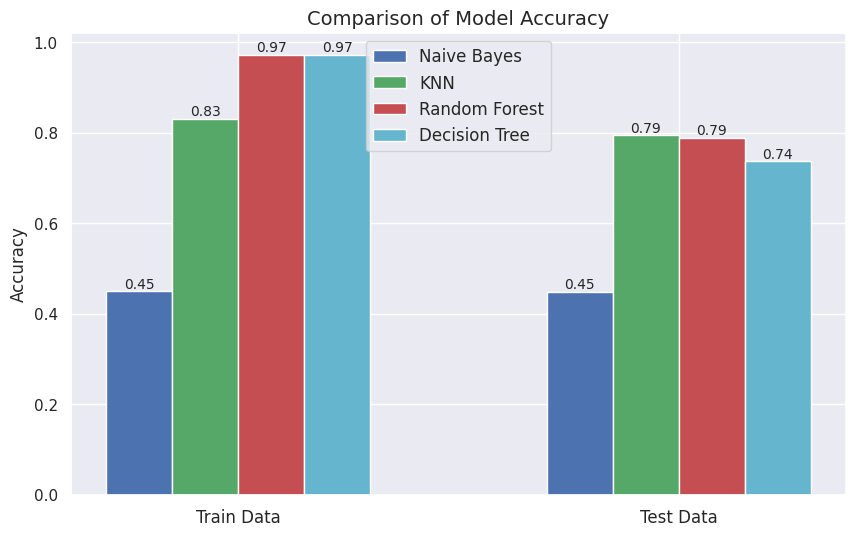

In [29]:
ind = np.arange(2)
width = 0.15
data = {
    'Naive Bayes': naive_bayes_score,
    'KNN': KNN_score,
    'Random Forest': random_score,
    'Decision Tree': decision_score
}

colors = ['b', 'g', 'r', 'c']

plt.figure(figsize=(10, 6))

for i, (label, scores) in enumerate(data.items()):
    plt.bar(ind + i * width, scores, width, label=label, color=colors[i])

plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Model Accuracy', fontsize=14)

plt.xticks(ind + width * (len(data) - 1) / 2, ('Train Data', 'Test Data'), fontsize=12)
plt.legend(fontsize=12)

# Add data labels
for i, (label, scores) in enumerate(data.items()):
    for j, score in enumerate(scores):
        plt.text(ind[j] + i * width, score, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

In [30]:
# from time import time
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     "n_estimators": [50, 100],
#     "max_depth": [None, 10,],
#     "min_samples_split": [2, 5],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["auto", "sqrt"],
#     "bootstrap": [True, False]
# }

# rfc = RandomForestClassifier(random_state=17, n_jobs=-1)

# n_iter_search = 15
# random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=n_iter_search, cv=5)

# start = time()
# random_search.fit(train_x, train_y)
# print(
#     "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
#     % ((time() - start), n_iter_search)
# )

# ***`MLFlow Practices:`***

In [25]:
import logging
import sys
import warnings
from urllib.parse import urlparse
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [ ]:
!pip3 install mlflow --upgrade

In [ ]:
!dagshub upload harryvasisht/ADAP data/ data/

# ***`Random Forest`***

In [26]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'harryvasisht'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4a7bea066695ef999dfda84bab1b8bba477df009'
remote_server_uri = "https://dagshub.com/harryvasisht/ADAP.mlflow"
with mlflow.start_run():
      mlflow.set_experiment("RandomForestTest")
      mlflow.autolog()
      RFC = RandomForestClassifier(alpha = 0.5, l1_ratio = 0.5, n_estimators=60,random_state=17,n_jobs=-1)
      RFC.fit(train_x, train_y)
      predicted_qualities = RFC.predict(test_x)
      (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
      print(f"  Alpha: {alpha}")
      print(f"  l1_ratio: {l1_ratio}")
      print(f"  RMSE: {rmse}")
      print(f"  MAE: {mae}")
      print(f"  R2: {r2}")
      mlflow.log_metric("rmse", rmse)
      mlflow.log_metric("r2", r2)
      mlflow.log_metric("mae", mae)
      predictions = RFC.predict(train_x)
      signature = infer_signature(train_x, predictions)
      mlflow.set_tracking_uri(remote_server_uri)
      tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
                # Model registry does not work with file store
      if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
                RFC, "model", registered_model_name="RandomForestClassifier", signature=signature
            )
      else:
        mlflow.sklearn.log_model(RFC, "model", signature=signature)

2023/10/21 20:23:36 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestTest' does not exist. Creating a new experiment.
2023/10/21 20:23:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/21 20:23:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/10/21 20:23:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2023/10/21 20:28:32 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


  RMSE: 1.284220231004849
  MAE: 0.513765395508134
  R2: 0.7228176739255991


MlflowException: ignored

In [30]:
mlflow.autolog()
# predicted_qualities = RFC.predict(test_x)
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  R2: {r2}")
mlflow.sklearn.log_model(RFC,"RandomForestClassifier")
# mlflow.log_metric("rmse", rmse)
# mlflow.log_metric("r2", r2)
# mlflow.log_metric("mae", mae)
# predictions = RFC.predict(train_x)
# signature = infer_signature(train_x, predictions)

2023/10/21 20:39:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/21 20:39:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


  RMSE: 1.284220231004849
  MAE: 0.513765395508134
  R2: 0.7228176739255991


MlflowException: ignored

## ***`Decison Tree`***

In [66]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'harryvasisht'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4a7bea066695ef999dfda84bab1b8bba477df009'
with mlflow.start_run():
      mlflow.set_experiment("DecisionTreeTest")
      mlflow.autolog()
      DT = DecisionTreeClassifier(criterion="entropy",random_state=17)
      DT.fit(train_x, train_y)
      predicted_qualities = DT.predict(test_x)
      (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
      print(f"  RMSE: {rmse}")
      print(f"  MAE: {mae}")
      print(f"  R2: {r2}")
      mlflow.log_metric("rmse", rmse)
      mlflow.log_metric("r2", r2)
      mlflow.log_metric("mae", mae)
      predictions = DT.predict(train_x)
      signature = infer_signature(train_x, predictions)
      remote_server_uri = "https://dagshub.com/harryvasisht/ADAP.mlflow"
      mlflow.set_tracking_uri(remote_server_uri)
      tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
                # Model registry does not work with file store
      if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
                DT, "model", registered_model_name="DecisionTreeClassifier", signature=signature
            )
      else:
        mlflow.sklearn.log_model(DT, "model", signature=signature)

2023/10/21 20:04:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/10/21 20:04:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/21 20:04:07 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2023/10/21 20:04:25 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


  RMSE: 1.434282911129107
  MAE: 0.6417166706531197
  R2: 0.6542547929095172


Successfully registered model 'DecisionTreeClassifier'.
2023/10/21 20:05:33 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 1
Created version '1' of model 'DecisionTreeClassifier'.


In [ ]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'harryvasisht'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4a7bea066695ef999dfda84bab1b8bba477df009'
with mlflow.start_run() as run:
      mlflow.set_experiment("DecisionTreeTest1")
      mlflow.autolog()
      alpha = 0.5 if float(0.5) is None else float(0.5)
       # Set default values if no l1_ratio is provided
      l1_ratio = 0.5 if float(0.5) is None else float(0.5)
      DT = DecisionTreeClassifier(alpha = alpha, l1_ratio = l1_ratio, criterion="entropy",random_state=17)
      DT.fit(train_x, train_y)
      predicted_qualities = DT.predict(test_x)
      (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
      print(f"  RMSE: {rmse}")
      print(f"  MAE: {mae}")
      print(f"  R2: {r2}")
      mlflow.log_metric("rmse", rmse)
      mlflow.log_metric("r2", r2)
      mlflow.log_metric("mae", mae)
      predictions = DT.predict(train_x)
      signature = infer_signature(train_x, predictions)
      remote_server_uri = "https://dagshub.com/harryvasisht/ADAP.mlflow"
      mlflow.set_tracking_uri(remote_server_uri)
      tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
      mlflow.sklearn.log_model(DT, "model", signature=signature)
      print(f"Run ID: {run.info.run_id}")
                # Model registry does not work with file store
      if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(
                DT, "model", registered_model_name="DecisionTreeClassifier1", signature=signature
            )
      else:
        mlflow.sklearn.log_model(DT, "model", signature=signature)

In [42]:
from dagshub.notebook import save_notebook
save_notebook(repo="harryvasisht/ADAP", path="/content/drive/MyDrive/Assignment Robotics/Assignment1.ipynb")

RuntimeError: ignored

# ***`CNN`***

9 by 9 and 3 by 3 kernel, from scratch. image using Numpy. With proper manner. atleast 1 iterration. plot Relu and Sigmoid. Leaky Relu


[!image] 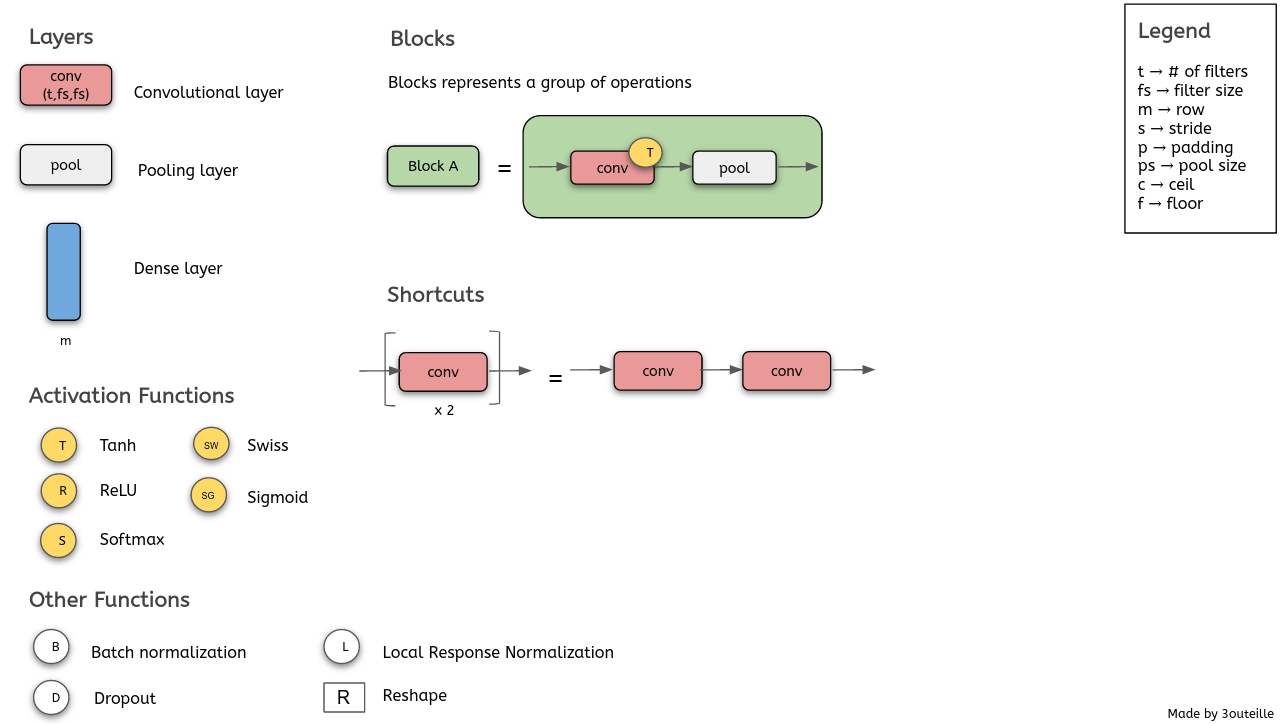

An RGB Image has 3 channels.

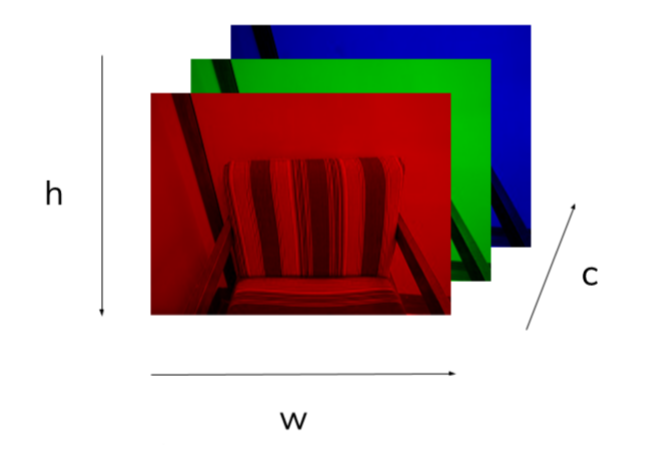

In [ ]:
import skimage.data
# Reading the image
img = skimage.data.chelsea()
# Converting the image into gray.
img = skimage.color.rgb2gray(img)

In [ ]:
# Define a 9x9 grayscale image
image = np.array([
    [10, 20, 30, 40, 50, 60, 70, 80, 90],
    [15, 25, 35, 45, 55, 65, 75, 85, 95],
    [12, 22, 32, 42, 52, 62, 72, 82, 92],
    [10, 20, 30, 40, 50, 60, 70, 80, 90],
    [15, 25, 35, 45, 55, 65, 75, 85, 95],
    [12, 22, 32, 42, 52, 62, 72, 82, 92],
    [10, 20, 30, 40, 50, 60, 70, 80, 90],
    [15, 25, 35, 45, 55, 65, 75, 85, 95],
    [12, 22, 32, 42, 52, 62, 72, 82, 92]
])

# Define a 3x3 kernel (edge detection)
kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])


image_height, image_width = image.shape
kernel_height, kernel_width = kernel.shape

output_height = image_height - kernel_height + 1
output_width = image_width - kernel_width + 1

# Initialize the output feature map
feature_map = np.zeros((output_height, output_width))

for i in range(output_height): # Perform convolution by sliding the kernel over the image
    for j in range(output_width):
        roi = image[i:i + kernel_height, j:j + kernel_width]
        feature_map[i, j] = np.sum(roi * kernel)


print("Image:")
print(image)
print("\nKernel:")
print(kernel)
print("\nFeature Map (Result of Convolution):")
print(feature_map)